# Realisez des indexations automatiques d'images

# SOMMAIRE

* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [DATASET](#CHARGEMENT)
* [CNN](#CNN)
    * [Layers visualization](#Layers-visualization)

# PREPARATION

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

## Import des librairies

In [16]:
import re
import joblib
import cv2
import glob
import numpy as np

import matplotlib.pyplot as plt
import random

import keras
import tensorflow as tf
import pydot
import graphviz
from keras.utils.vis_utils import plot_model

from sklearn. model_selection import train_test_split

## Paramètrage du notebook

## Déclaration des fonctions

In [17]:
from keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten
from keras.models import Model

def conv3x3(input_x,nb_filters):
    """
    Wrapper around convolution layer
    Inputs:
        input_x: input layer / tensor
        nb_filter: Number of filters for convolution
    """
    return Conv2D(nb_filters, kernel_size=(3,3), use_bias=False,
               activation='relu', padding="same",input_shape=(128, 128, 3))(input_x)

def std_image(image):
        image=image.astype('float32') # convert from integers to floats
        image-= image.mean()
        image/= image.std ()
        image*=  64
        image+= 128
        image/=255 # normalize to the range 0-1
        return image

def create_model(img_h=28, img_w=28):
    """
    Creates a CNN model for training. 
    Inputs: 
        img_h: input image height
        img_w: input image width
    Returns:
        Model structure 
    """
    
    inputs = Input(shape=(img_h, img_w, 3))

    x = conv3x3(inputs, 32)
    x = conv3x3(x, 32)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 64)
    x = conv3x3(x, 64)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 128)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    preds = Dense(nb_class, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=preds)
    print(model.summary())
    return model

In [18]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_2(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32,
        (3,3),
        input_shape=(img_h,img_w,3), 
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    model.add(tf.keras.layers.Conv2D(64,
        (3,3),
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(120,
        activation='softmax'))
    print(model.summary())
    return model

In [19]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_3(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()
    model.add(keras.Input(shape=(img_h, img_w, 3)))
    model.add(tf.keras.layers.Rescaling(1./255))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(120, activation="softmax"))
    print(model.summary())
    return model

# CHARGEMENT

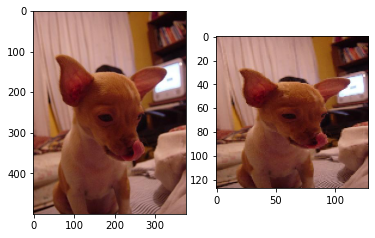

In [20]:
# DEBUG - comparaison entre l'original et l'image retaillée

imgs=[]

for img in glob.glob("/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg"):
    #print(img)
    i=cv2.imread(img,cv2.IMREAD_COLOR)
    imgs.append(i)

original=imgs[35][:,:,::-1] #opencv defaults read color into BGR -> convert to RGB
resized=cv2.resize(original, (128, 128),interpolation = cv2.INTER_NEAREST)
plt.subplot(1, 2, 1)
plt.imshow(original)

plt.subplot(1, 2, 2)
plt.imshow(resized)

plt.show()

In [21]:
# liste des fichiers
#filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg')
filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/*/*.jpg')

In [22]:
#XSubset=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/XSubset.jbl.bz2')
#ySubset=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/ySubset.jbl.bz2')

# DATASET

In [23]:
# chargement des labels (a partir des noms de repertoires)

dogTypes=[]
for file in filelist:
    #print(f"[{i}]-{file}")
    d=re.match("\S+\/n\d+-(.*)\/\S+.jpg",file)
    dogType=d.group(1)
    dogTypes.append(dogType)
len(dogTypes)

20580

In [24]:
%%time
# numpy array des images (format numpy)
X = np.array([cv2.resize(cv2.imread(file)[:,:,::-1], (128, 128),interpolation = cv2.INTER_NEAREST) for file in filelist])
X.shape, X.nbytes

CPU times: user 1min, sys: 3.67 s, total: 1min 4s
Wall time: 1min 5s


((20580, 128, 128, 3), 1011548160)

In [25]:
# dictionnaire index-> race chien
dictDogTypes=dict(enumerate(np.unique(dogTypes)))
# dictionnaire inversé race chien->classe
dictClasses = dict(map(reversed, dictDogTypes.items()))

dictClasses

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [26]:
y=[dictClasses[dogType] for dogType in dogTypes]

In [27]:
N=10000 # nombres de photos dans l'échantillon
# selection d'index de photo et labels au hasard
randomIndices=random.sample(list(np.arange(len(X))),N)
randomIndices

[6765,
 5383,
 1271,
 10097,
 10980,
 140,
 12293,
 16884,
 9478,
 15029,
 12902,
 574,
 6273,
 13562,
 15281,
 7178,
 12669,
 9901,
 6843,
 12627,
 15800,
 16765,
 4784,
 14288,
 9667,
 18400,
 12993,
 8260,
 10486,
 17670,
 14996,
 5045,
 8253,
 14953,
 4995,
 8847,
 16650,
 7123,
 19029,
 9544,
 19422,
 2094,
 18692,
 3795,
 11920,
 7621,
 16969,
 15430,
 2009,
 19072,
 11888,
 9835,
 2591,
 590,
 8460,
 9327,
 4200,
 20491,
 20012,
 13019,
 12985,
 8647,
 8205,
 2772,
 9509,
 11275,
 9619,
 17091,
 18969,
 14962,
 5320,
 8991,
 18190,
 13653,
 15729,
 13835,
 13417,
 10941,
 15705,
 2733,
 13287,
 2002,
 17936,
 3997,
 9084,
 14852,
 10920,
 8003,
 7176,
 12875,
 8985,
 14425,
 19782,
 11534,
 14635,
 8035,
 6561,
 20445,
 14127,
 10289,
 13139,
 2106,
 19706,
 7951,
 12411,
 14083,
 19485,
 2341,
 10843,
 4885,
 18567,
 16879,
 16774,
 11619,
 11952,
 17553,
 8829,
 17077,
 8575,
 10560,
 18083,
 14633,
 7678,
 3335,
 8163,
 18801,
 6391,
 14566,
 1867,
 6010,
 11338,
 17201,
 110

In [28]:
XSubset=X[randomIndices]
ySubset=np.array(y)[randomIndices]

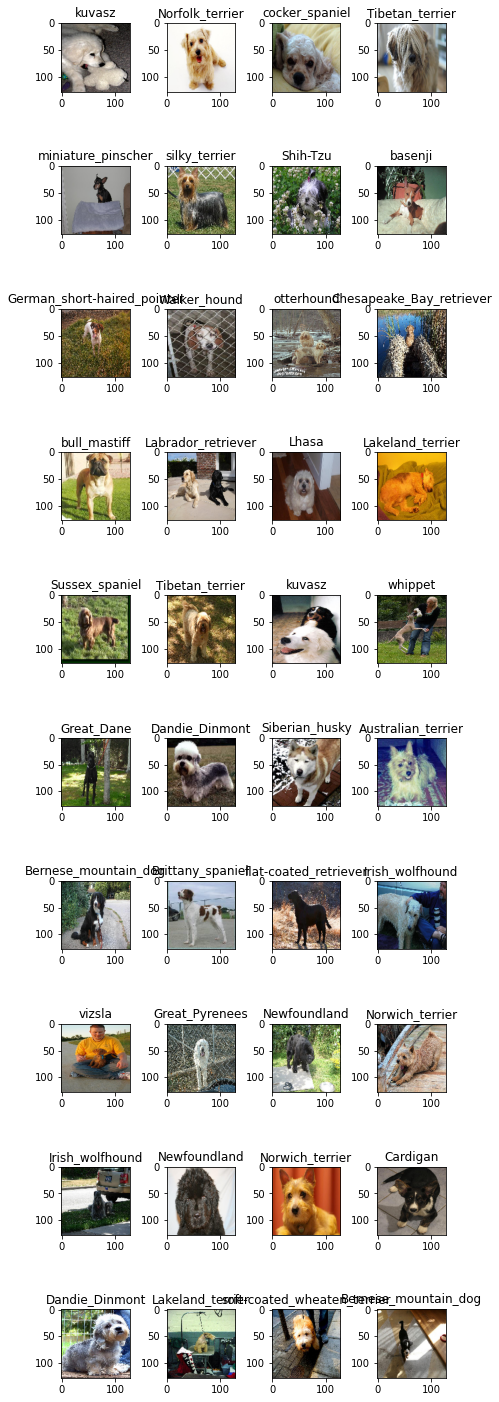

In [29]:
# specify the number of rows and columns you want to see
num_row =10
num_col = 4

# get a segment of the dataset
num = num_row*num_col
images = XSubset[:num]
labels = ySubset[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title(f'{dictDogTypes[labels[i]]}')
plt.tight_layout()
plt.show()

# CNN

## Random

In [30]:
# setup parameters
batch_sz = 128  # batch size 
nb_class = 120  # target number of classes
nb_epochs = 20 # training epochs
img_h, img_w = 128, 128  # input dimensions

In [31]:
X_train, X_test, y_train, y_test = train_test_split(XSubset, ySubset, test_size=0.3, random_state=42)

In [32]:
X_train[0].shape

(128, 128, 3)

In [33]:
model = create_model_2(128,128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 120)               7

2022-01-06 18:02:39.923087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
# setup optimizer, loss function and metrics for model
model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

In [48]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('mnist_cnn.h5')

In [49]:
X_train.shape,y_train.shape

((7000, 128, 128, 3), (7000,))

In [50]:
%%time
# start training
history=model.fit(X_train, y_train,
          batch_size=batch_sz,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(X_test, y_test), 
          callbacks=[callback])

/Users/hui-guan/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
55/55 [==============================] - 86s 2s/step - loss: 62.0773 - accuracy: 0.0111 - val_loss: 4.7872 - val_accuracy: 0.0147
Epoch 2/20
55/55 [==============================] - 87s 2s/step - loss: 4.2312 - accuracy: 0.1481 - val_loss: 5.2510 - val_accuracy: 0.0153
Epoch 3/20
55/55 [==============================] - 87s 2s/step - loss: 2.3543 - accuracy: 0.5021 - val_loss: 7.9467 - val_accuracy: 0.0270
Epoch 4/20
55/55 [==============================] - 85s 2s/step - loss: 0.9587 - accuracy: 0.7914 - val_loss: 11.9697 - val_accuracy: 0.0293
Epoch 5/20
55/55 [==============================] - 84s 2s/step - loss: 0.3744 - accuracy: 0.9253 - val_loss: 15.9377 - val_accuracy: 0.0340
Epoch 6/20
55/55 [==============================] - 84s 2s/step - loss: 0.1611 - accuracy: 0.9731 - val_loss: 16.9094 - val_accuracy: 0.0317
Epoch 7/20
55/55 [==============================] - 84s 2s/step - loss: 0.0898 - accuracy: 0.9859 - val_loss: 21.0338 - val_accuracy: 0.0337
Epoch 8/20
55/5

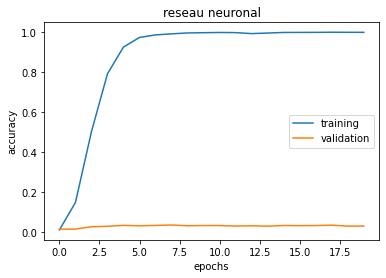

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('reseau neuronal')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [52]:
# Evaluate and print accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 21.03304100036621
Test accuracy: 0.03033333271741867


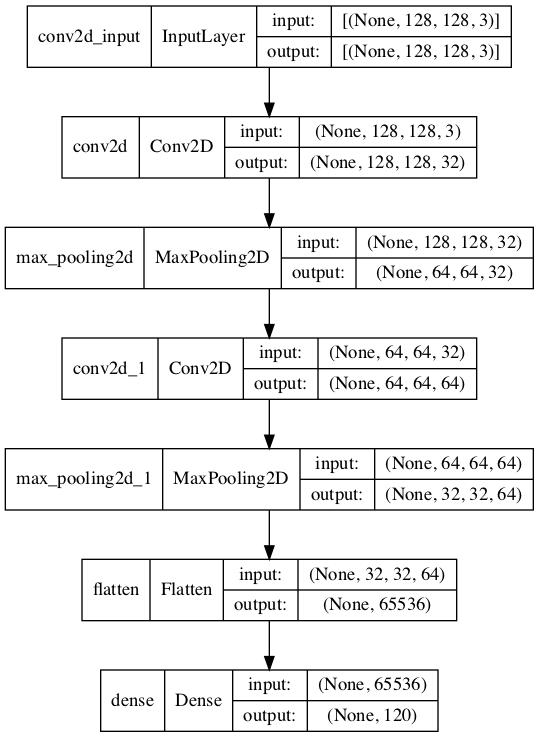

In [34]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

# API

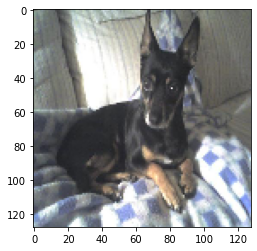

In [35]:
img=XSubset[77]
plt.imshow(img)
image=(np.expand_dims(img, axis=0)).astype(float)
image=std_image(image)

In [62]:
x_pred=model.predict(image)
x_pred[0]

array([0.0081625 , 0.00810495, 0.00870354, 0.00862504, 0.00746303,
       0.00844418, 0.00868091, 0.00811791, 0.00746662, 0.00853273,
       0.00825225, 0.00884145, 0.00785722, 0.0084928 , 0.00733127,
       0.00875913, 0.00834763, 0.0090133 , 0.0087507 , 0.00865353,
       0.00856612, 0.00859673, 0.00856922, 0.00849448, 0.00858857,
       0.0092835 , 0.0088702 , 0.00851398, 0.00798664, 0.00878578,
       0.00770706, 0.0076741 , 0.00863534, 0.00861347, 0.00809349,
       0.00765125, 0.00727839, 0.00916599, 0.00834945, 0.00791808,
       0.00906814, 0.00805978, 0.00745907, 0.00800283, 0.00914967,
       0.00841818, 0.00838575, 0.00920903, 0.00908161, 0.00887956,
       0.00931009, 0.00880016, 0.00792192, 0.0079857 , 0.00813884,
       0.00776569, 0.00833904, 0.00828688, 0.00824435, 0.00812977,
       0.00876286, 0.00890155, 0.00853921, 0.00794577, 0.00798318,
       0.00847808, 0.00864452, 0.00912584, 0.00862695, 0.00866544,
       0.00891461, 0.00831705, 0.00781503, 0.00806292, 0.00815

In [64]:
y_pred=np.argmax(x_pred[0])
y_pred

50

In [65]:
x_pred[0][50]

0.009310094

In [66]:
dictDogTypes[50]

'Old_English_sheepdog'

## Layers visualization

### Filters

In [55]:
for layer in model.layers:    
    if 'conv' in layer.name:            
        filters , bias = layer.get_weights()
        print(layer.name , filters.shape) #filters.shape = A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]

conv2d_2 (3, 3, 3, 32)
conv2d_3 (3, 3, 32, 64)


In [56]:
filters.shape[3]

64

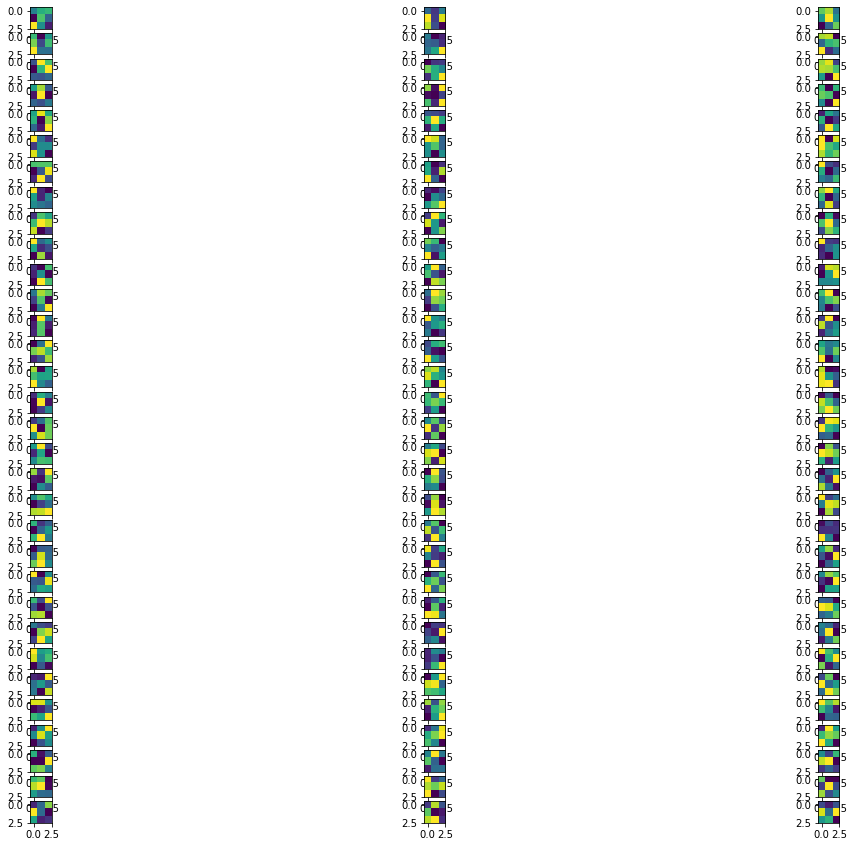

In [57]:
# retrieve weights from the hidden layer
filters , bias = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

#n_filters =32
n_filters=filters.shape[3]
j=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for channel in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,j)
        plt.imshow(f[:,:,channel])
        j+=1
#plot the filters 
plt.show()

### Features

In [58]:
# couches de convolution
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' in layer.name:    
        print(i , layer.name , layer.output.shape)

0 conv2d_2 (None, 128, 128, 32)
2 conv2d_3 (None, 64, 64, 64)


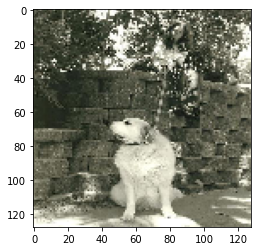

In [59]:
img=XSubset[77]
plt.imshow(img)
image=(np.expand_dims(img, axis=0)).astype(float)
image=std_image(image)

In [60]:
len(model.layers)

6

In [61]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)-2]]
# couches d'activation avec entrées et sorties
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs) #puts together the input and output functions of the CNN model

In [62]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 128, 128, 3)]    0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
Total params: 19,392
Trainable params: 19,392
Non-trainable p

In [63]:
#calculating features
activations = activation_model.predict(image)

/Users/hui-guan/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [64]:
for activation_layer in activation_model.layers:
    print(f"Shape of {activation_layer.name} -> {activation_layer.output.shape}")

Shape of conv2d_2_input -> (None, 128, 128, 3)
Shape of conv2d_2 -> (None, 128, 128, 32)
Shape of max_pooling2d_2 -> (None, 64, 64, 32)
Shape of conv2d_3 -> (None, 64, 64, 64)
Shape of max_pooling2d_3 -> (None, 32, 32, 64)


In [65]:
len(activations), range(len(activations)-1)

(4, range(0, 3))

(1, 64, 64, 64) 64


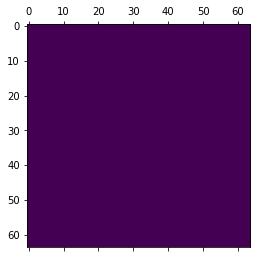

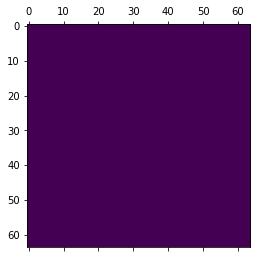

In [67]:
# Getting Activations of first layer
nth_layer_activation = activations[2]
  
# shape of first layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3])
  
# 6th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 0], cmap ='viridis')
  
# 15th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 2], cmap ='viridis')

In [68]:
range(1,nth_layer_activation.shape[3]), 32//8, 32%8

(range(1, 64), 4, 0)

(1, 64, 64, 64) 63


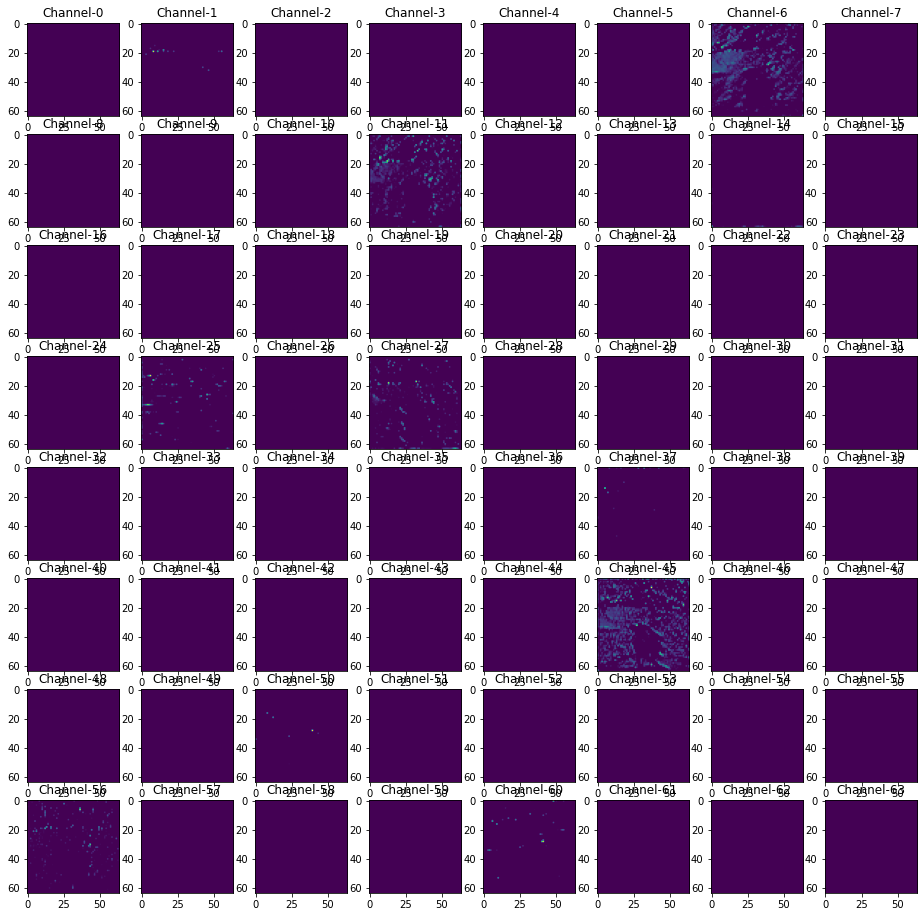

In [69]:
n=2
num_row=8
num_col=8


# Gettubg activation of nth layer
nth_layer_activation = activations[n]
  
# shape of nth layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3]-1)

# plot activation layer's channels
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

for c in range(nth_layer_activation.shape[3]):
    ax = axes[c//num_col, c%num_col]
    ax.imshow(nth_layer_activation[0, :, :, c], cmap='viridis')
    ax.set_title(f'Channel-{c}')
plt.show()